In [5]:
import cv2
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from tqdm import tqdm

In [3]:
revchecker_nc = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_ephys_merge.json'

In [31]:
revchecker_nc = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_ephys_merge.json'

In [3]:
revchecker_nc = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012821/EE8P6LT/hf4_revchecker/012821_EE8P6LT_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012821/EE8P6LT/hf4_revchecker/012821_EE8P6LT_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012821/EE8P6LT/hf4_revchecker/012821_EE8P6LT_control_Rig2_hf4_revchecker_ephys_merge.json'

In [21]:
revchecker_nc = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/hf4_revchecker/012221_G6H30P3LN_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/hf4_revchecker/012221_G6H30P3LN_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/012221/G6H30P3LN/hf4_revchecker/012221_G6H30P3LN_control_Rig2_hf4_revchecker_ephys_merge.json'

In [3]:
def read_ephys_bin(binpath, ch_num, do_remap=True):
    if ch_num!=16 and ch_num!=64:
        print('not 16 or 64 ch probe -- check arg ch_num')
        return None
    if ch_num == 16:
        ch_remap = [15,18,10,23,11,22,12,21,9,24,13,20,14,19,16,17] - 8
        dtypes = np.dtype([("ch"+str(i),np.uint16) for i in range(0,16)])
    elif ch_num == 64:
        ch_remap = [32,62,33,63,34,60,36,61,37,58,38,59,40,56,41,57,42,54,44,55,
                    45,52,46,53,47,50,43,51,39,48,35,49,0,30,1,31,2,28,3,26,4,27,
                    5,24,6,22,7,23,8,20,9,18,10,19,11,16,12,17,13,21,14,25,15,29]
        dtypes = np.dtype([("ch"+str(i),np.uint16) for i in range(0,64)])
    # read in binary file
    ephys = pd.DataFrame(np.fromfile(binpath, dtypes, -1, ''))
    # remap with known order of channels
    if do_remap is True:
        ephys = ephys.iloc[:,list(ch_remap)]
    return ephys

In [4]:
ephys = read_ephys_bin(revchecker_bin, 64)

In [94]:
from scipy.signal import sosfiltfilt, sosfilt

In [16]:
def butter_lowpass_filter(data, cutoff, fs, order=6):
    normal_cutoff = cutoff / (0.5 * fs)
    sos = butter(order, normal_cutoff, output='sos')
    return sosfiltfilt(sos, data)

In [81]:
file_ephys = butter_lowpass_filter(ephys, 4, 30000)

In [123]:
np.shape(file_ephys)

(4497408, 64)

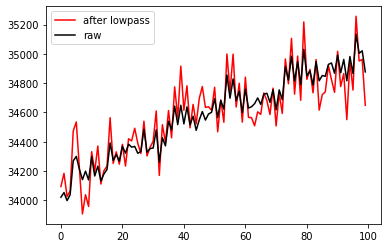

In [121]:
plt.plot(file_ephys[300:400,0],'r')
plt.plot(np.array(ephys)[300:400,0],'k')
plt.legend(['after lowpass', 'raw'])

In [203]:
np.shape(file_ephys)

(4497408, 64)

In [419]:
ephys_center_sub = ephys - np.mean(ephys,0)

In [240]:
np.shape(ephys_center_sub)

(4497408, 64)

In [265]:
ephys_center_sub_ch10 = ephys_center_sub.iloc[1000:5000,10]
# np.shape(ephys_center_sub_ch10[:,np.newaxis])

In [288]:
def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandpass', output='sos')
#     sos = butter(order, high, btype='lowpass', output='sos')
    return sosfiltfilt(sos, data, axis=0)

filtered_ephys = butter_bandpass(ephys_center_sub, lowcut=1, highcut=300, fs=30000, order=6)

In [289]:
np.shape(filtered_ephys)

(4497408, 64)

Text(0.5, 1.0, 'bandpass, 1:300, sosfiltfilt, axis=0')

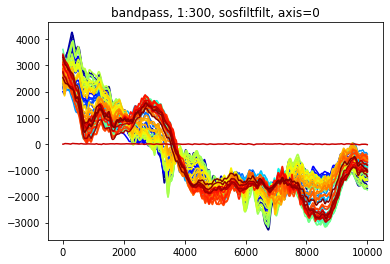

In [293]:
for i in range(64):
    plt.plot(filtered_ephys[5000:15000,i], color=colors[i])
plt.title('bandpass, 1:300, sosfiltfilt, axis=0')

In [69]:
b, a = butter(6, (1,300), btype='bandpass', fs=30000)
filtered_ephys = lfilter(b, a, file_ephys)

In [53]:
filtered_ephys = fitlered_ephys

In [70]:
colors = plt.cm.Blues(np.linspace(0,1,64)) # darker is deeper

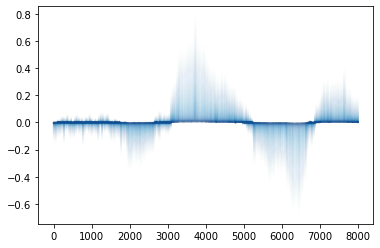

In [71]:
for i in range(64):
    plt.plot(fitlered_ephys[2000:10000,i], color=colors[i], alpha=0.1)
plt.show()

In [215]:
filt_ephys = low_pass_ephys_filt(ephys)

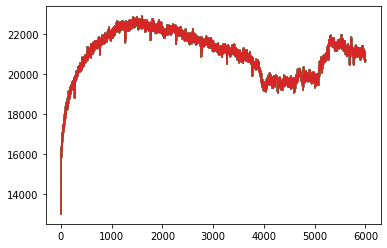

In [230]:
plt.plot(file_ephys[:6000])

In [35]:
world = xr.open_dataset(revchecker_nc)

In [36]:
world

<xarray.Dataset>
Dimensions:      (frame: 9039, height: 120, width: 160)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 6 ... 9033 9034 9035 9036 9037 9038
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 ...

In [38]:
world_vid = world.WORLD_video.astype(np.uint8)

In [39]:
from sklearn.cluster import MiniBatchKMeans

In [40]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 2

In [41]:
num_frames = np.size(world_vid,0)
vid_width = np.size(world_vid,1)
vid_height = np.size(world_vid,2)
kmeans_input = world_vid.values.reshape(num_frames,vid_width*vid_height)

In [42]:
compactness, labels, centers = cv2.kmeans(kmeans_input.astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [43]:
labels = np.ndarray.flatten(labels)

In [44]:
label_diff = np.diff(labels)

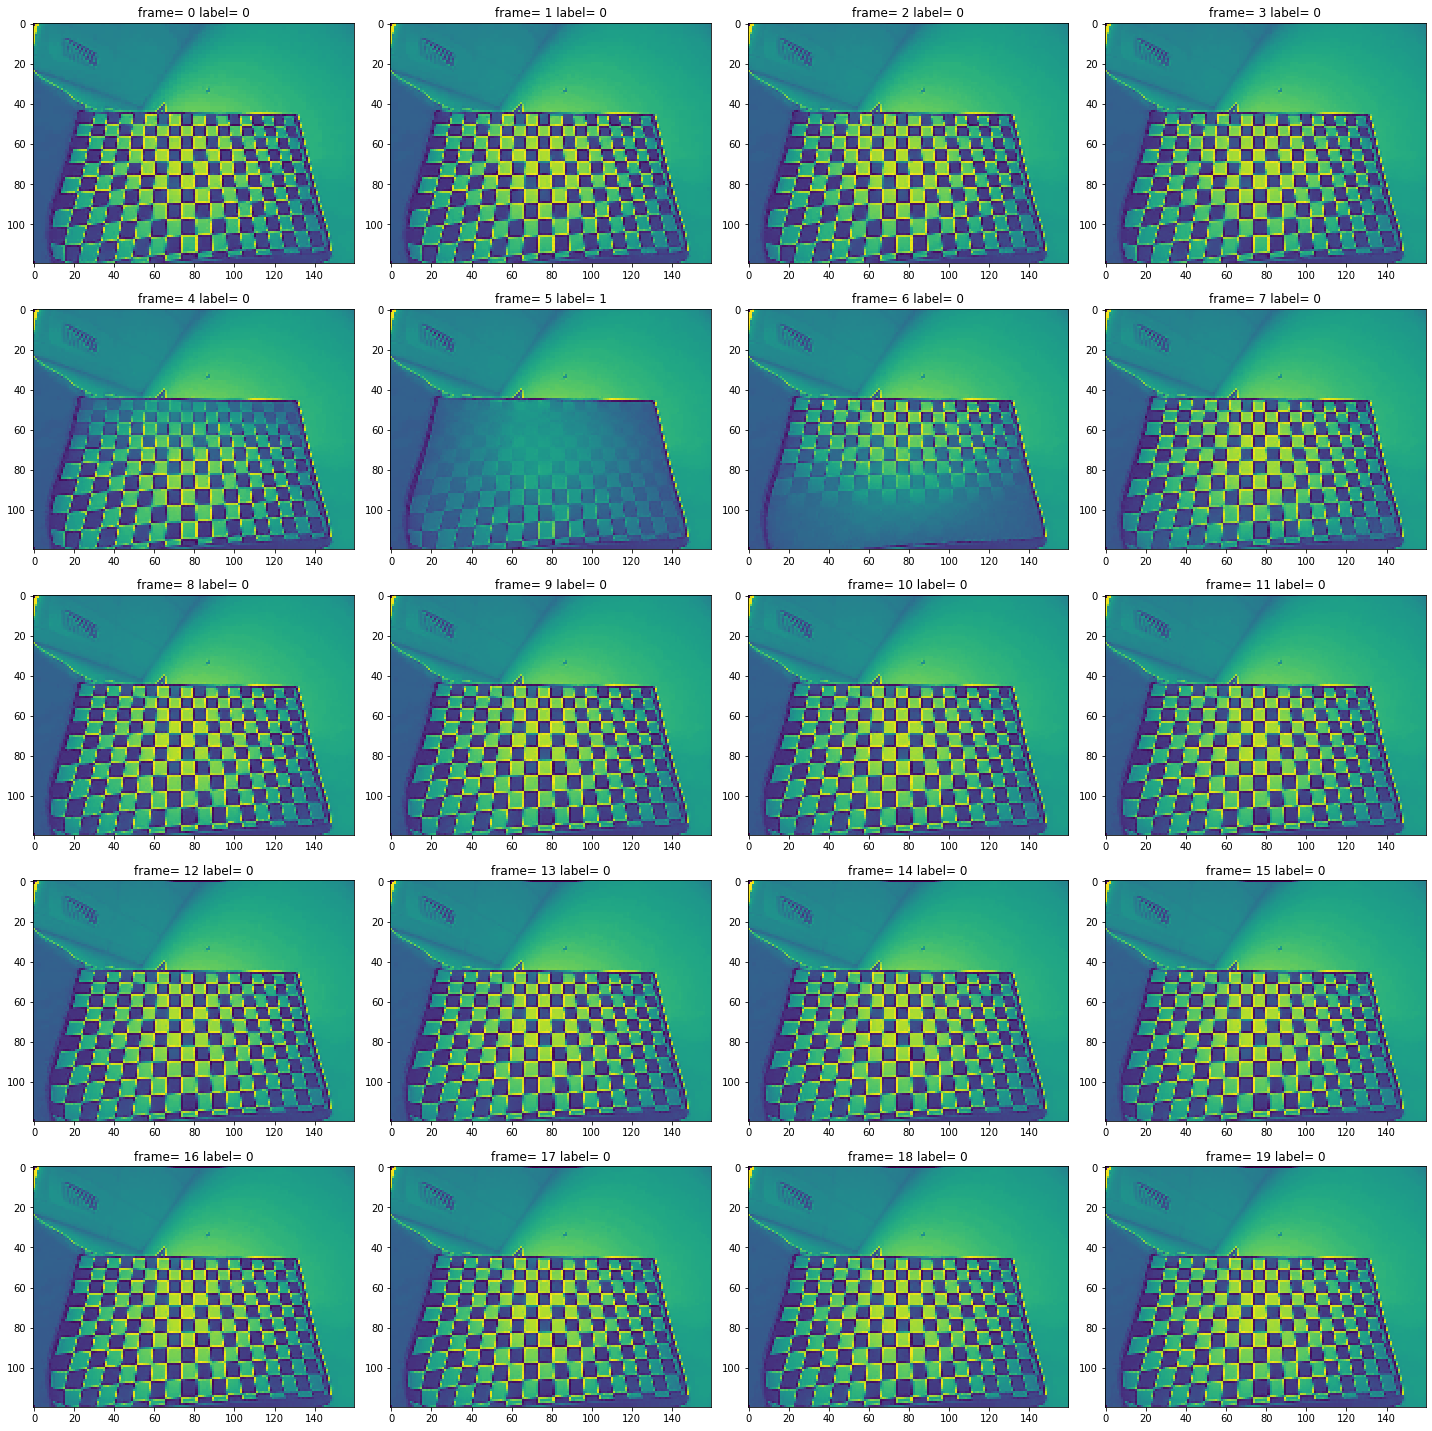

In [153]:
plt.subplots(5,4, figsize=(20,20))
for step in range(20):
    frame = world_vid[step]
    plt.subplot(5,4,step+1)
    plt.imshow(frame)
    plt.title('frame= '+str(step)+' label= '+str(label_diff[step]))
plt.tight_layout()
plt.show()

In [45]:
revind = list(abs(label_diff))

In [22]:
# get 3d diff between consecutive frames
def video_diff(world_vid):
    all_sum = []
    for step in tqdm(range(np.size(world_vid,0)-1)):
        frame = world_vid[step].astype(float)
        next_frame = world_vid[step+1].astype(float)
        diff = next_frame - frame
        all_sum.append(np.sum(diff**2))
    return all_sum

In [23]:
full_diff = world_diff(world_vid)

100%|██████████| 9038/9038 [00:10<00:00, 876.77it/s]


In [19]:
full_diff_crop = full_diff.copy()
full_diff_crop[full_diff_crop > 220] = 0

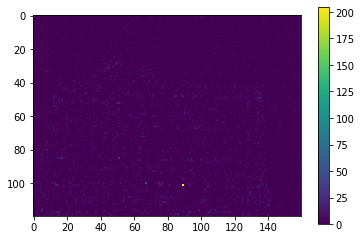

In [20]:
plt.imshow(full_diff_crop[:,:,23])
plt.colorbar()

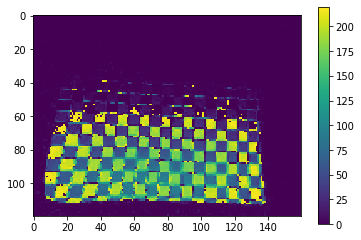

In [21]:
plt.imshow(full_diff_crop[:,:,40])
plt.colorbar()

In [22]:
# get the sum of pixel-by-pixel differences for each frame in x and y
sum_diff = []
for step in range(np.size(full_diff_crop,2)):
    frame = full_diff_crop[:,:,step]
    sum_diff.append(np.sum(frame**2))

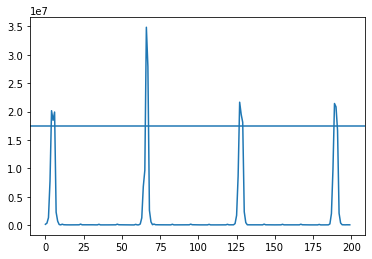

In [26]:
plt.plot(full_diff[:200])
plt.axhline(y=1.75e7)

In [27]:
sum_diff_arr = np.array(full_diff)
revframes = sum_diff_arr>1.75e7

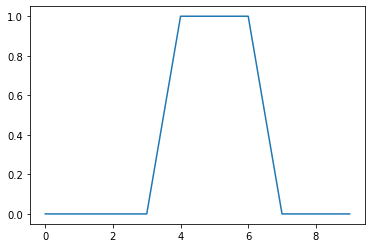

In [74]:
plt.plot(revframes[:10])

False


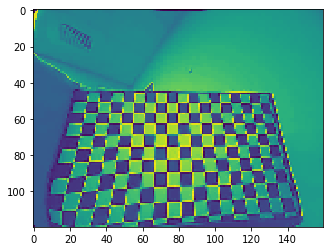

False


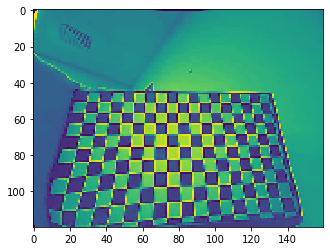

False


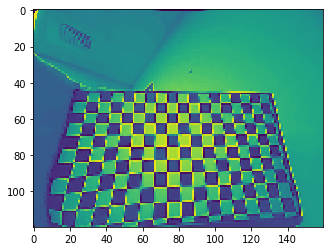

False


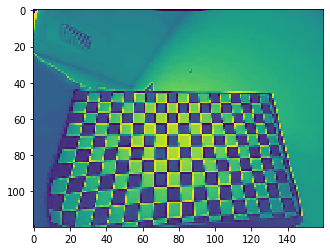

True


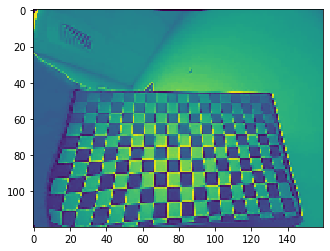

True


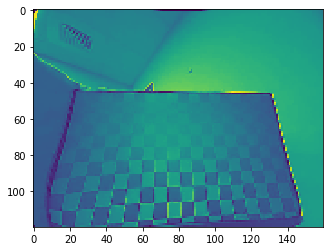

True


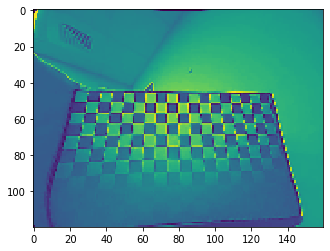

False


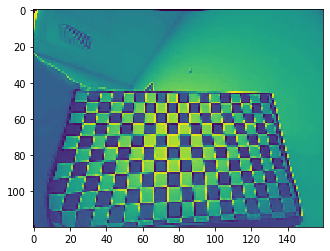

False


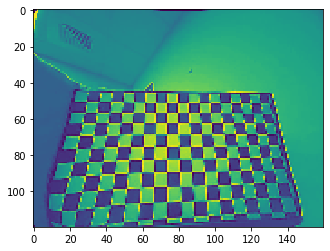

False


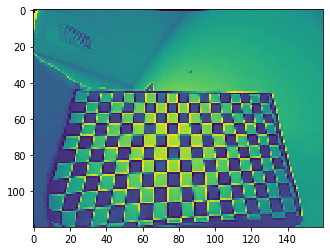

False


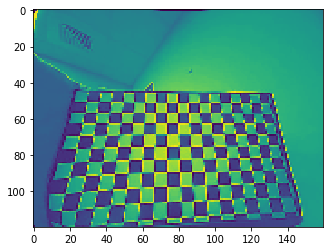

False


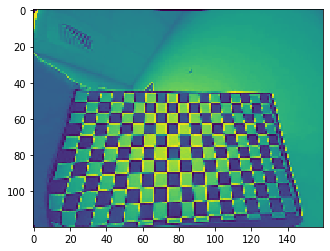

False


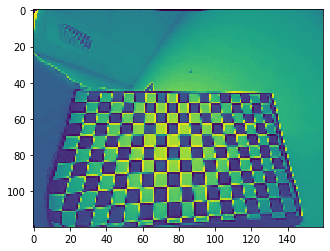

False


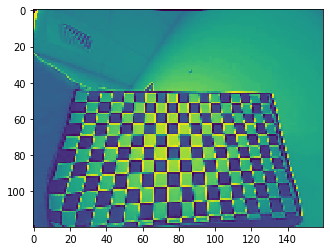

False


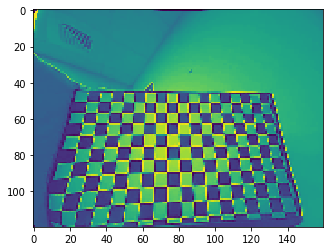

False


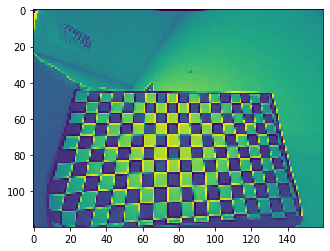

False


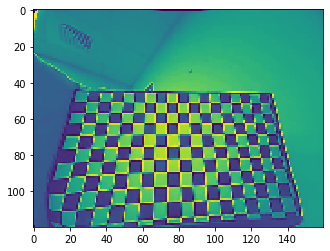

False


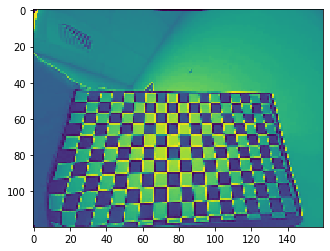

False


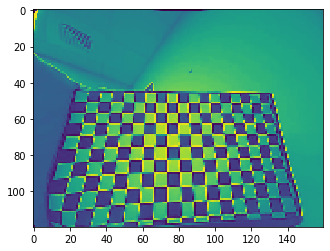

False


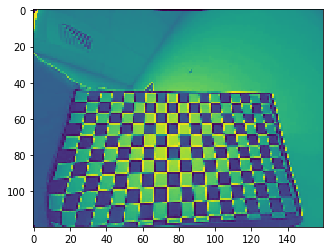

In [92]:
for step in range(20):
    print(revframes[step])
    plt.imshow(world_vid[step])
    plt.show()

In [81]:
revind = [True if (revframes[i] == 0 and revframes[i+1] == 1) else False for i in range(len(revframes)-1)]

(0, 1.5)

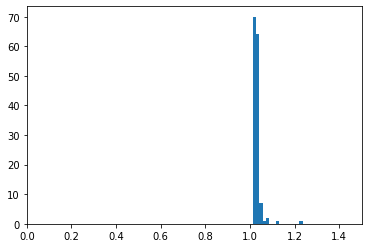

In [196]:
plt.hist(np.diff(worldT[np.where(revind)]),bins=15)
plt.xlim([0,1.5])

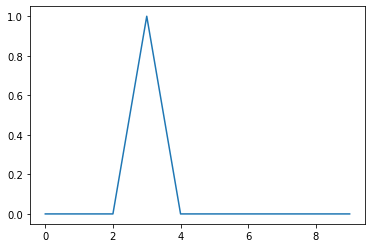

In [82]:
plt.plot(revind[:10])

In [6]:
ephys_data = pd.read_json(revchecker_ephys_json)
ephysT0 = ephys_data.iloc[0,12]
worldT = world['timestamps'].values - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60

NameError: name 'world' is not defined

In [47]:
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

In [48]:
samprate = 30000

In [294]:
win_start = 0.1; win_end = 0.5 # sec
all_resp = np.zeros([np.size(filtered_ephys, 1), np.sum(revind), len(list(set(np.arange(1-win_start, 1+win_end, 1/samprate))))])
true_rev_index = 0
for rev_index, rev_label in tqdm(enumerate(revind)):
    if rev_label == 1 and worldT[rev_index] > 1:
        for ch_num in range(np.size(filtered_ephys, 1)):
            bin_start = int((worldT[rev_index]-win_start)*samprate); bin_end = int((worldT[rev_index]+win_end)*samprate)
            if bin_end < np.size(filtered_ephys, 0):
                all_resp[ch_num, true_rev_index] = filtered_ephys[bin_start:bin_end, ch_num]
        true_rev_index = true_rev_index + 1

9038it [00:00, 18527.79it/s]


In [295]:
rev_resp_mean = np.mean(all_resp, 1)

([<matplotlib.axis.XTick at 0x7f7dbd92dad0>,
 <a list of 5 Text xticklabel objects>)

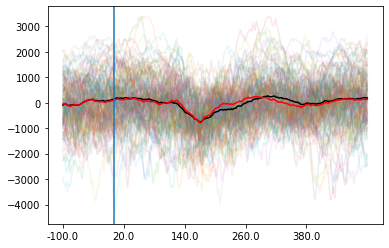

In [296]:
plt.plot(all_resp[40].T, alpha=0.1)
plt.plot(rev_resp_mean[40], 'k')
plt.plot(rev_resp_mean[1], 'r')
plt.axvline(x=win_start*samprate)
plt.xticks(np.arange(0,18000,18000/5),np.arange(-100,500,600/5))
# plt.savefig('/home/niell_lab/Documents/figures/040921_revchecker/ch11.png')

32

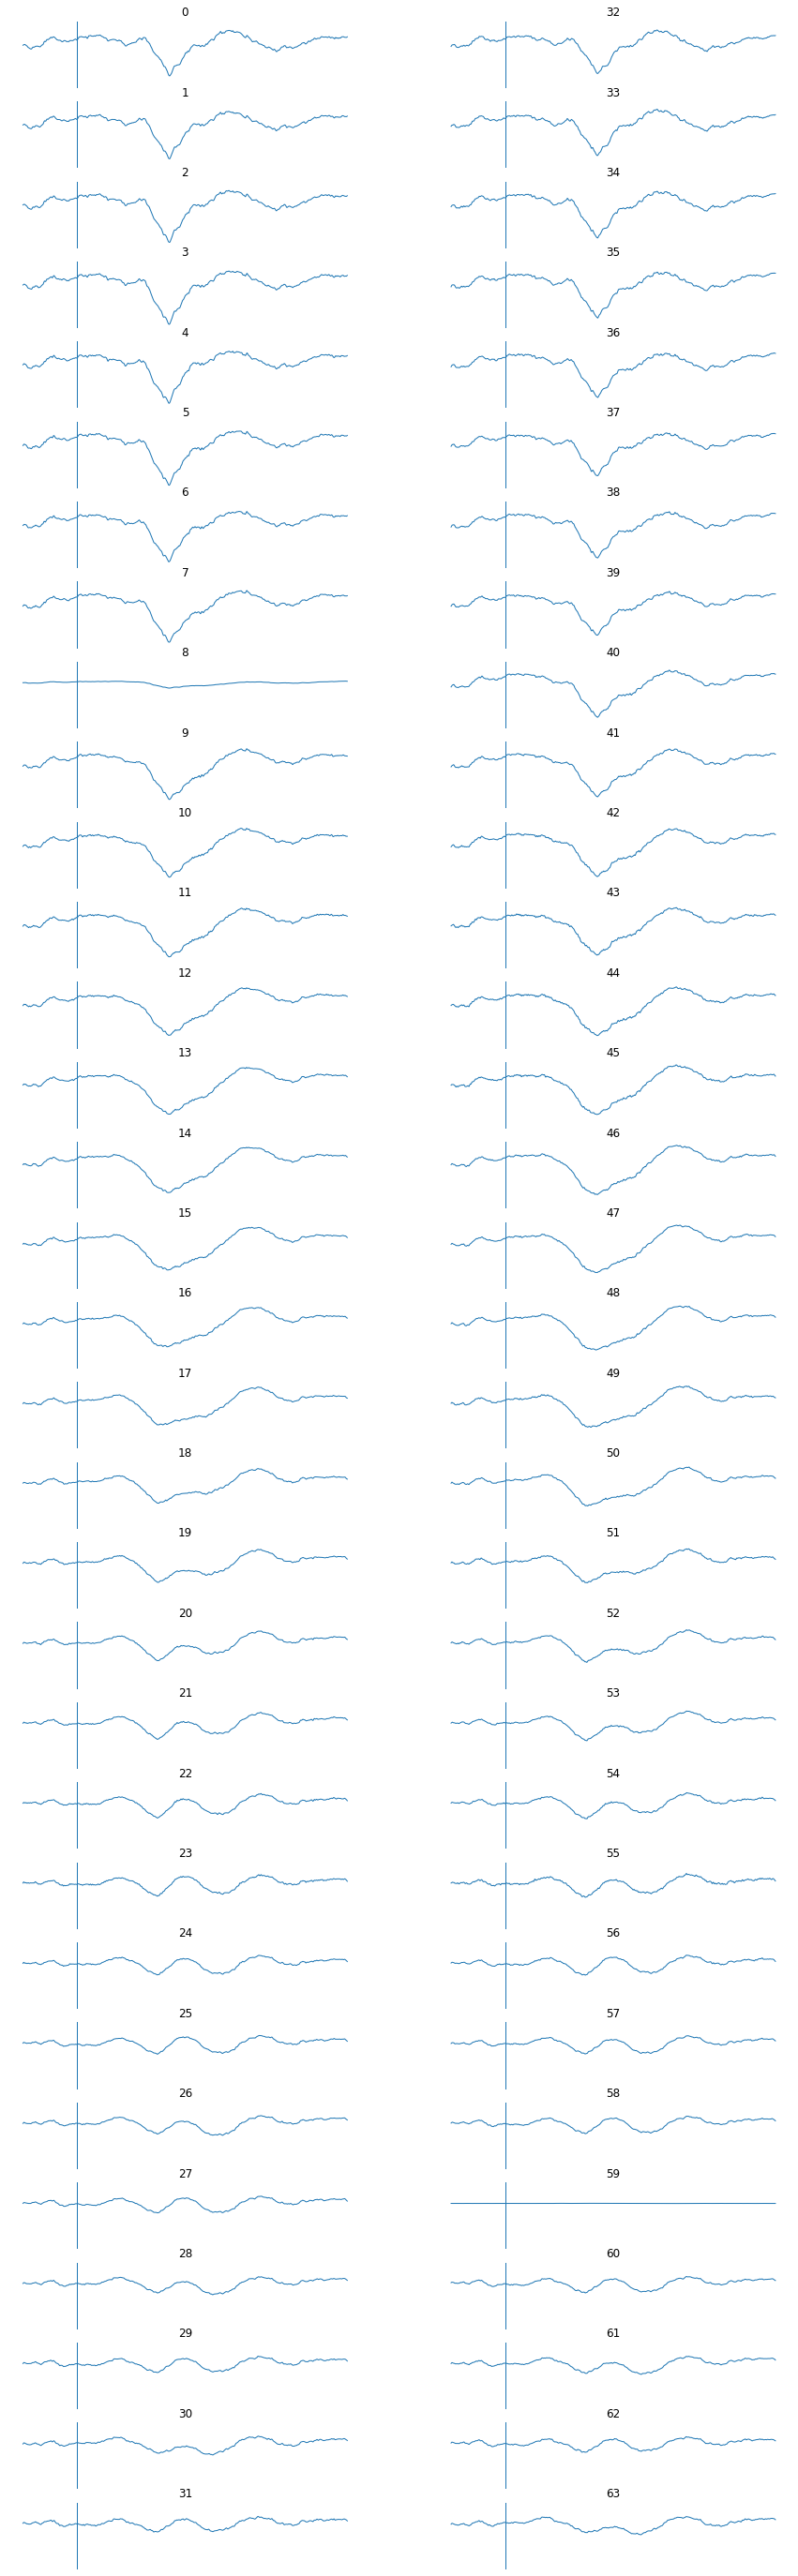

In [436]:
fig, axes = plt.subplots(int(np.size(rev_resp_mean,0)/2),2, figsize=(15,50),sharey=True)
ch_num = 0
for ax in axes.T.flatten():
    ax.plot(rev_resp_mean[ch_num], linewidth=1)
    ax.axvline(x=(0.1*samprate), linewidth=1)
    ax.axis('off')
    ax.set_title(ch_num)
    ch_num = ch_num + 1
plt.show()
# plt.savefig('/home/niell_lab/Documents/figures/040921_revchecker/all_units.png')

In [333]:
colors = plt.cm.jet(np.linspace(0,1,32))

/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/ipykernel_

IndexError: index 32 is out of bounds for axis 0 with size 32

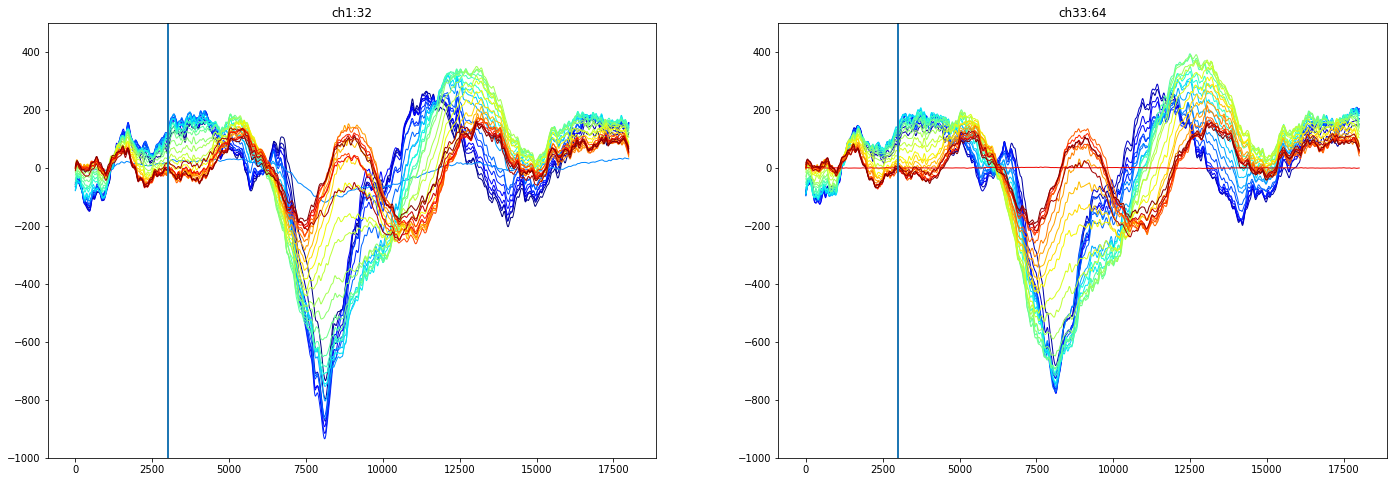

In [344]:
plt.subplots(1,2 ,figsize=(24,8))
for ch_num in np.arange(0,64):
    if ch_num<=31:
        plt.subplot(1,2,1)
        plt.plot(rev_resp_mean[ch_num], color=colors[ch_num], linewidth=1)
        plt.title('ch1:32')
        plt.axvline(x=(0.1*samprate))
        plt.ylim([-1000,500])
    if ch_num>31:
        plt.subplot(1,2,2)
        plt.plot(rev_resp_mean[ch_num], color=colors[ch_num-31], linewidth=1)
        plt.title('ch33:64')
        plt.axvline(x=(0.1*samprate))
        plt.ylim([-1000,500])
plt.show()

In [425]:
csd = np.ones([np.size(rev_resp_mean,0), np.size(rev_resp_mean,1)])
csd_interval = 2
for ch in range(2,np.size(rev_resp_mean,0)-2):
    csd[ch] = rev_resp_mean[ch] - 0.5*(rev_resp_mean[ch-csd_interval] + rev_resp_mean[ch+csd_interval])

In [426]:
2+np.size(rev_resp_mean,0)

66

In [427]:
ch = 0
print(ch-csd_interval)

-2


In [428]:
csd = csd

/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'no norm')

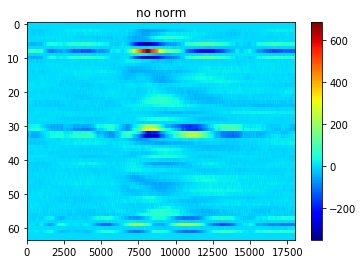

In [429]:
fig, ax = plt.subplots(1,1)
plt.subplot(1,1,1)
plt.imshow(csd, cmap='jet')
plt.axes().set_aspect('auto')
plt.colorbar()
plt.title('no norm')

In [417]:
csd_interp = np.interp(csd, (csd.min(), csd.max()), (-1, +1))

/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


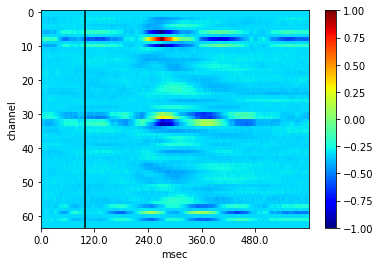

In [440]:
fig, ax = plt.subplots(1,1)
plt.subplot(1,1,1)
plt.imshow(csd_interp, cmap='jet')
plt.axes().set_aspect('auto')
plt.colorbar()
plt.xticks(np.arange(0,18000,18000/5),np.arange(0,600,600/5))
plt.xlabel('msec'); plt.ylabel('channel')
plt.axvline(x=(0.1*samprate), color='k')

In [1]:
# find ch to unit labels

In [7]:
ephys_data = pd.read_json(revchecker_ephys_json)

In [8]:
ephys_data

,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,waveform,spikeT,t0
0,3303.4,136.3,mua,100.684143,1,751,0.825111,noise,6295,0,"[0.0553207807, 0.0556498915, 0.0540209897, 0.0...","[5.6184, 17.0287333333, 23.578, 28.8301333333,...",42768.29102
1,1943.5,28.4,mua,117.513664,1,751,0.521281,noise,3977,0,"[0.007845797600000001, 0.0264028478, 0.0285360...","[3.8076333333, 17.0862, 23.9685666667, 24.1733...",42768.29102
2,939.6,63.3,mua,62.382095,0,776,7.032512,noise,53653,0,"[0.035603594, 0.0371664986, 0.0383806787000000...","[0.33736666670000004, 1.4162, 1.73689999999999...",42768.29102
3,717.6,356.9,mua,41.706783,6,626,0.297014,noise,2266,0,"[-0.0099894274, -0.0081166904, -0.005757042200...","[0.2810333333, 5.4261, 13.0022, 13.6611666667,...",42768.29102
4,1431.9,129.5,mua,67.776825,0,776,0.024118,noise,184,0,"[-0.0390035883, -0.0368397236, -0.0383257866, ...",[],42768.29102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,1187.2,167.1,mua,89.025833,33,751,0.013238,noise,101,0,"[0.0520151593, 0.0900045633, 0.0874080211, 0.0...",[],42768.29102
227,1144.0,195.0,mua,88.696587,33,751,0.018219,noise,139,0,"[0.052080825000000004, 0.089961201, 0.08724568...",[],42768.29102
228,5950.1,125.6,mua,67.999413,50,326,0.077334,noise,590,0,"[-0.0192763843, -0.0295284521, -0.0334557928, ...",[],42768.29102
229,1900.2,146.7,mua,45.407391,56,176,0.067634,noise,516,0,"[0.0693192035, 0.07412610950000001, 0.07543993...",[],42768.29102
